#### Author: Kunyu He, The University of Chicago, CAPP'20

# 1. Executive Summary

# 2. Introduction

When it comes to property taxes, Cook County, where Chicago is located, has one of the biggest and most complicated bases in the country: there are nearly 2 million taxable properties that generate billions in revenue for the county. Figuring out a rational, and fair, method to assign each property a value, and thus determine how it should be taxed, is a herculean data analytics problem with real money and real lives at stake.

The responsibility for creating a model that assigns values to properties for the purposes of taxation lies with the Cook County Assessor’s Office (CCAO). In this particular case, CCAO is interested in better understanding data relating to valuation of single family homes as part of the process of building an accurate valuation model. The task is to explore a dataset to gain insight into it's usefulness in the property assessment process.

In [1]:
import sys
sys.path.append('../../codes/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrix
import utils

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
sns.set_style("whitegrid")

pd.options.display.float_format = '{:.3f}'.format  # suppress scientific notation
pd.options.mode.chained_assignment = None

# 3. Data

The dataset is collected by CCAO and it consists of a random sample of homes that have sold in the three regions of Cook County (Northern Townships, City of Chicago, Southwest Townships) during tax years 2003-2018. A data dictionary is also provided.

- `PIN`: Unique Permanent Identification Number for each property. All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode
- `Property Address`: Property street address, not the address of the taxpayer.
- `Tax Year`: Tax year of sale. Tax year referrs to the year in which taxes due. Taxes are billed a year in arrears. If a sale ocurred in calendar year 2018, it will be in tax year 2019.
- `Property Class`: Property class. For a list of property classes, see https://www.cookcountyassessor.com/assets/forms/classcode.pdf
- `Census Tract`: Census tract identifier - full map available through the Census Bureau, https://www.census.gov/geo/maps-data/maps/2010ref/st17_tract.html
- `Type of Residence`: Type of residence - 1 = one story, 2 = two-story, 3 = three-story or higher, 4 = split level, 5 = 1.5 story, 6 = 1.6 story, 7 = 1.7 story , 8 = 1.8 story , 9 = 1.9 story (Note: residences with 1.5 - 1.9 stories are one story and have partial livable attics and are classified based on the square footage of the attic compared to the first floor of the house. So, 1.5 story houses have an attic that is 50% of the area of the first floor, 1.6 story houses are 60%, 1.7 are 70%, etc. However, what is recorded on the field card differs from what is in the database. All 1.5 - 1.9 story houses are coded as 5)
- `Rooms`: Number of rooms in the property (excluding baths). Not to be confused with bedrooms.
- `Bedrooms`: Number of bedrooms in the property, defined based on building squarefoot and the judgement of the person in the field.
- `Basement`: Basement type - 1 = Full, 2 = Slab, 3 = Partial, 4 = Crawl
- `Fireplaces`: Number of fireplaces, counted as the number of flues one can see from the outside of the building.
- `Central Air`: Is central airconditioning present? - 1 = yes, 2 = no
- `Full Baths`: Number of full bathrooms, defined as having a bath or shower. If this value is missing, the default value is set to 1.
- `Half Baths`: Number of half baths, defined as bathrooms without a shower or bathtub.
- `Building Square Feet`: Building square feet, as measured from the exterior of the property
- `Land Square Feet`: Square feet of the land (not just the building) of the property. Note that land is divided into 'plots' and 'parcels' - this field applies to parcels, identified by PIN
- `Age`: Age of the property. If missing, this defaults to 10. This field is a combination of original age and effective age where original age refers to the oldest component of the building and effective age is a relative judgement due to renovations or other improvements. For instance, if a property is completely demolished and built up again, the age resets to 1. But if portions of the original structure are kept, it may be more complicated to determine the age.
- `Longitude`: Longitude coordinate of the property's location, as defined by the centroid of the parcel shape in GIS.
- `Latitude`: Latitude coordinate of the property's location, as defined by the centroid of the parcel shape in GIS.
- `Walkscore`: Walkability score on a 100 point scale, using property distance to amenities. https://www.walkscore.com/methodology.shtml
- `Walkfac`: Walkscores transferred into a 4 level category variable ranging from 'car-dependent' to "walker's paradise".  https://www.walkscore.com/methodology.shtm
- `Sale Price`: Sale price

Read the dataset.

In [4]:
df = pd.read_csv('project1data.csv')
df.sample(3)

,PIN,Property_Address,Tax_Year,Property_Class,Census_Tract,Type_of_Residence,Rooms,Bedrooms,Basement,Fireplaces,...,Full_Baths,Half_Baths,Building_Square_Feet,Land_Square_Feet,Age,Longitude,Latitude,Walkscore,Walkfac,Sale_Price
15964,7153150000000,105 DES PLAINES LN HOFFMAN ESTATES,2018,203,804709.000,1.0,6.000,3.000,4.0,0.000,...,1.000,1.000,1205.000,12242.000,59.000,-88.082,42.038,45.000,Car-Dependent,185000
981,6244140000000,177 HAZELNUT DR STREAMWOOD,2018,295,804308.000,2.0,6.000,3.000,2.0,0.000,...,1.000,1.000,1287.000,3216.000,28.000,-88.150,42.018,66.000,Somewhat Walkable,102000
2246,17091121071345,7028 ROBERTS DR,2011,299,842300.000,NaN,nan,nan,NaN,nan,...,nan,nan,nan,nan,nan,-88.057,41.758,30.000,Car-Dependent,450000


Make sure we only take single-family homes. Subset the dataset to Property Class 202-209, 234, and 278.

In [5]:
df = df[df.Property_Class.isin(list(range(202, 210)) + [234, 278])
        & (df.Sale_Price > 10000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10949 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PIN                   10949 non-null  int64  
 1   Property_Address      10949 non-null  object 
 2   Tax_Year              10949 non-null  int64  
 3   Property_Class        10949 non-null  int64  
 4   Census_Tract          10948 non-null  float64
 5   Type_of_Residence     10889 non-null  object 
 6   Rooms                 10889 non-null  float64
 7   Bedrooms              10889 non-null  float64
 8   Basement              10889 non-null  object 
 9   Fireplaces            10889 non-null  float64
 10  Central_Air           10889 non-null  object 
 11  Full_Baths            10913 non-null  float64
 12  Half_Baths            10889 non-null  float64
 13  Building_Square_Feet  10889 non-null  float64
 14  Land_Square_Feet      10913 non-null  float64
 15  Age                

To augment this dataset, we will also use several supplementary data sources from City of Chicago Data Portal:
- `CTA - Bus Stops - kml`: Point data representing over 11,000 CTA bus stops. ([link](https://data.cityofchicago.org/Transportation/CTA-Bus-Stops-kml/84eu-buny), [download link](https://data.world/cityofchicago/cta-bus-stops))
- `CTA - 'L' (Rail) Stations - kml`: Point data representing approximate location of Station head house. ([link](https://data.cityofchicago.org/Transportation/CTA-L-Rail-Stations-kml/4qtv-9w43), [download link](https://data.world/cityofchicago/cta-l-rail-stations-shapefile))

# 4. EDA and Data Cleaning

## 4.1 Remove Unnecessary Features

`PIN` and `Census_Tract`

Fix `PIN` column to 14 digit as described.

In [6]:
df['PIN'] = df.PIN.astype(str)
df.PIN.str.len().value_counts()

14    7872
13    3077
Name: PIN, dtype: int64

In [7]:
df['PIN'] = df.PIN.str.pad(width=14, side='left', fillchar='0')
df['PIN'].str[:-8].nunique()

4330

There is less unique area + subareas than census tracts, use `PIN` for area fix effects.

Keep the area and sub area code and remove `Census_Tract`. Leave `PIN` temporarily for feature engineering.

In [8]:
df['Area_Code'] = df.PIN.str[:2].astype('category')
df['Sub_Area_Code'] = df.PIN.str[:4].astype('category')
df['Block_Code'] = df.PIN.str[:6].astype('category')

df.drop(['Census_Tract'], axis=1, inplace=True)

`Property_Address`

In [9]:
df.drop(['Property_Address'], axis=1, inplace=True)

## 4.2 Missing Values

In [10]:
df.isna().sum()

PIN                      0
Tax_Year                 0
Property_Class           0
Type_of_Residence       60
Rooms                   60
Bedrooms                60
Basement                60
Fireplaces              60
Central_Air             60
Full_Baths              36
Half_Baths              60
Building_Square_Feet    60
Land_Square_Feet        36
Age                     36
Longitude                0
Latitude                 0
Walkscore                0
Walkfac                  0
Sale_Price               0
Area_Code                0
Sub_Area_Code            0
Block_Code               0
dtype: int64

A small set of observations have missing values. Just drop them to make things easier.

In [11]:
df.dropna(axis=0, inplace=True)

In [12]:
df.apply(lambda col: (col == "?").sum() if col.dtype == 'object' else 0)

PIN                       0
Tax_Year                  0
Property_Class            0
Type_of_Residence       881
Rooms                     0
Bedrooms                  0
Basement                  0
Fireplaces                0
Central_Air               0
Full_Baths                0
Half_Baths                0
Building_Square_Feet      0
Land_Square_Feet          0
Age                       0
Longitude                 0
Latitude                  0
Walkscore                 0
Walkfac                   0
Sale_Price                0
Area_Code                 0
Sub_Area_Code             0
Block_Code                0
dtype: int64

Deal with this issue later.

## 4.3 Numeric Variables

`Sale_Price`

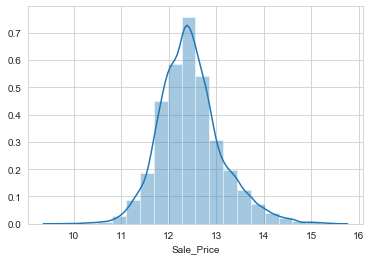

In [13]:
sns.distplot(np.log(df.Sale_Price), bins=20)

In [14]:
df['log_Sale_Price'] = np.log(df.Sale_Price)

`Age`

Note the interesting shape of Age - a multimodal, non normal distribution. The dip in count at age 80 - likely caused by the aftermath of the Great Depression. And the peak construction era, after WWII.

Age should be binned as levels in a category. Change to categorical and bins age ranges ('2006+','2005-1976','1975-1946','1945-').

In [15]:
bins = [0, 2019 - 2006, 2019 - 1976, 2019 - 1946, 300]
labels = ['2006+', '2005-1976', '1975-1946', '1945-']

df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels)

`Building_Square_Feet`

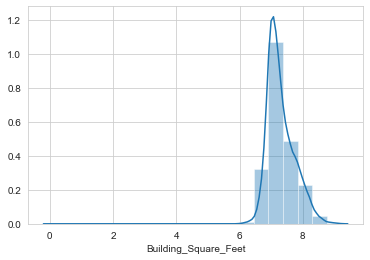

In [16]:
sns.distplot(np.log(df.Building_Square_Feet + 1), bins=20)

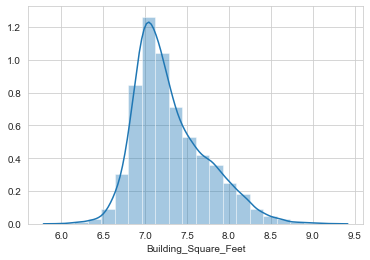

In [17]:
df = df[df.Building_Square_Feet >= 10]
df['Building_Square_Feet'] = np.log(df.Building_Square_Feet)
sns.distplot(df.Building_Square_Feet, bins=20)

`Land_Square_Feet`

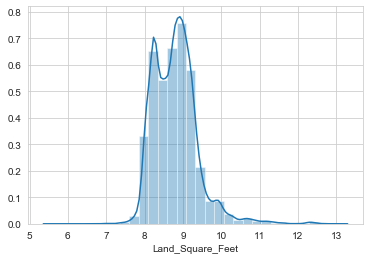

In [18]:
sns.distplot(np.log(df.Land_Square_Feet), bins=30)
df['Land_Square_Feet'] = np.log(df.Land_Square_Feet)

`Latitude` and `Longitude`

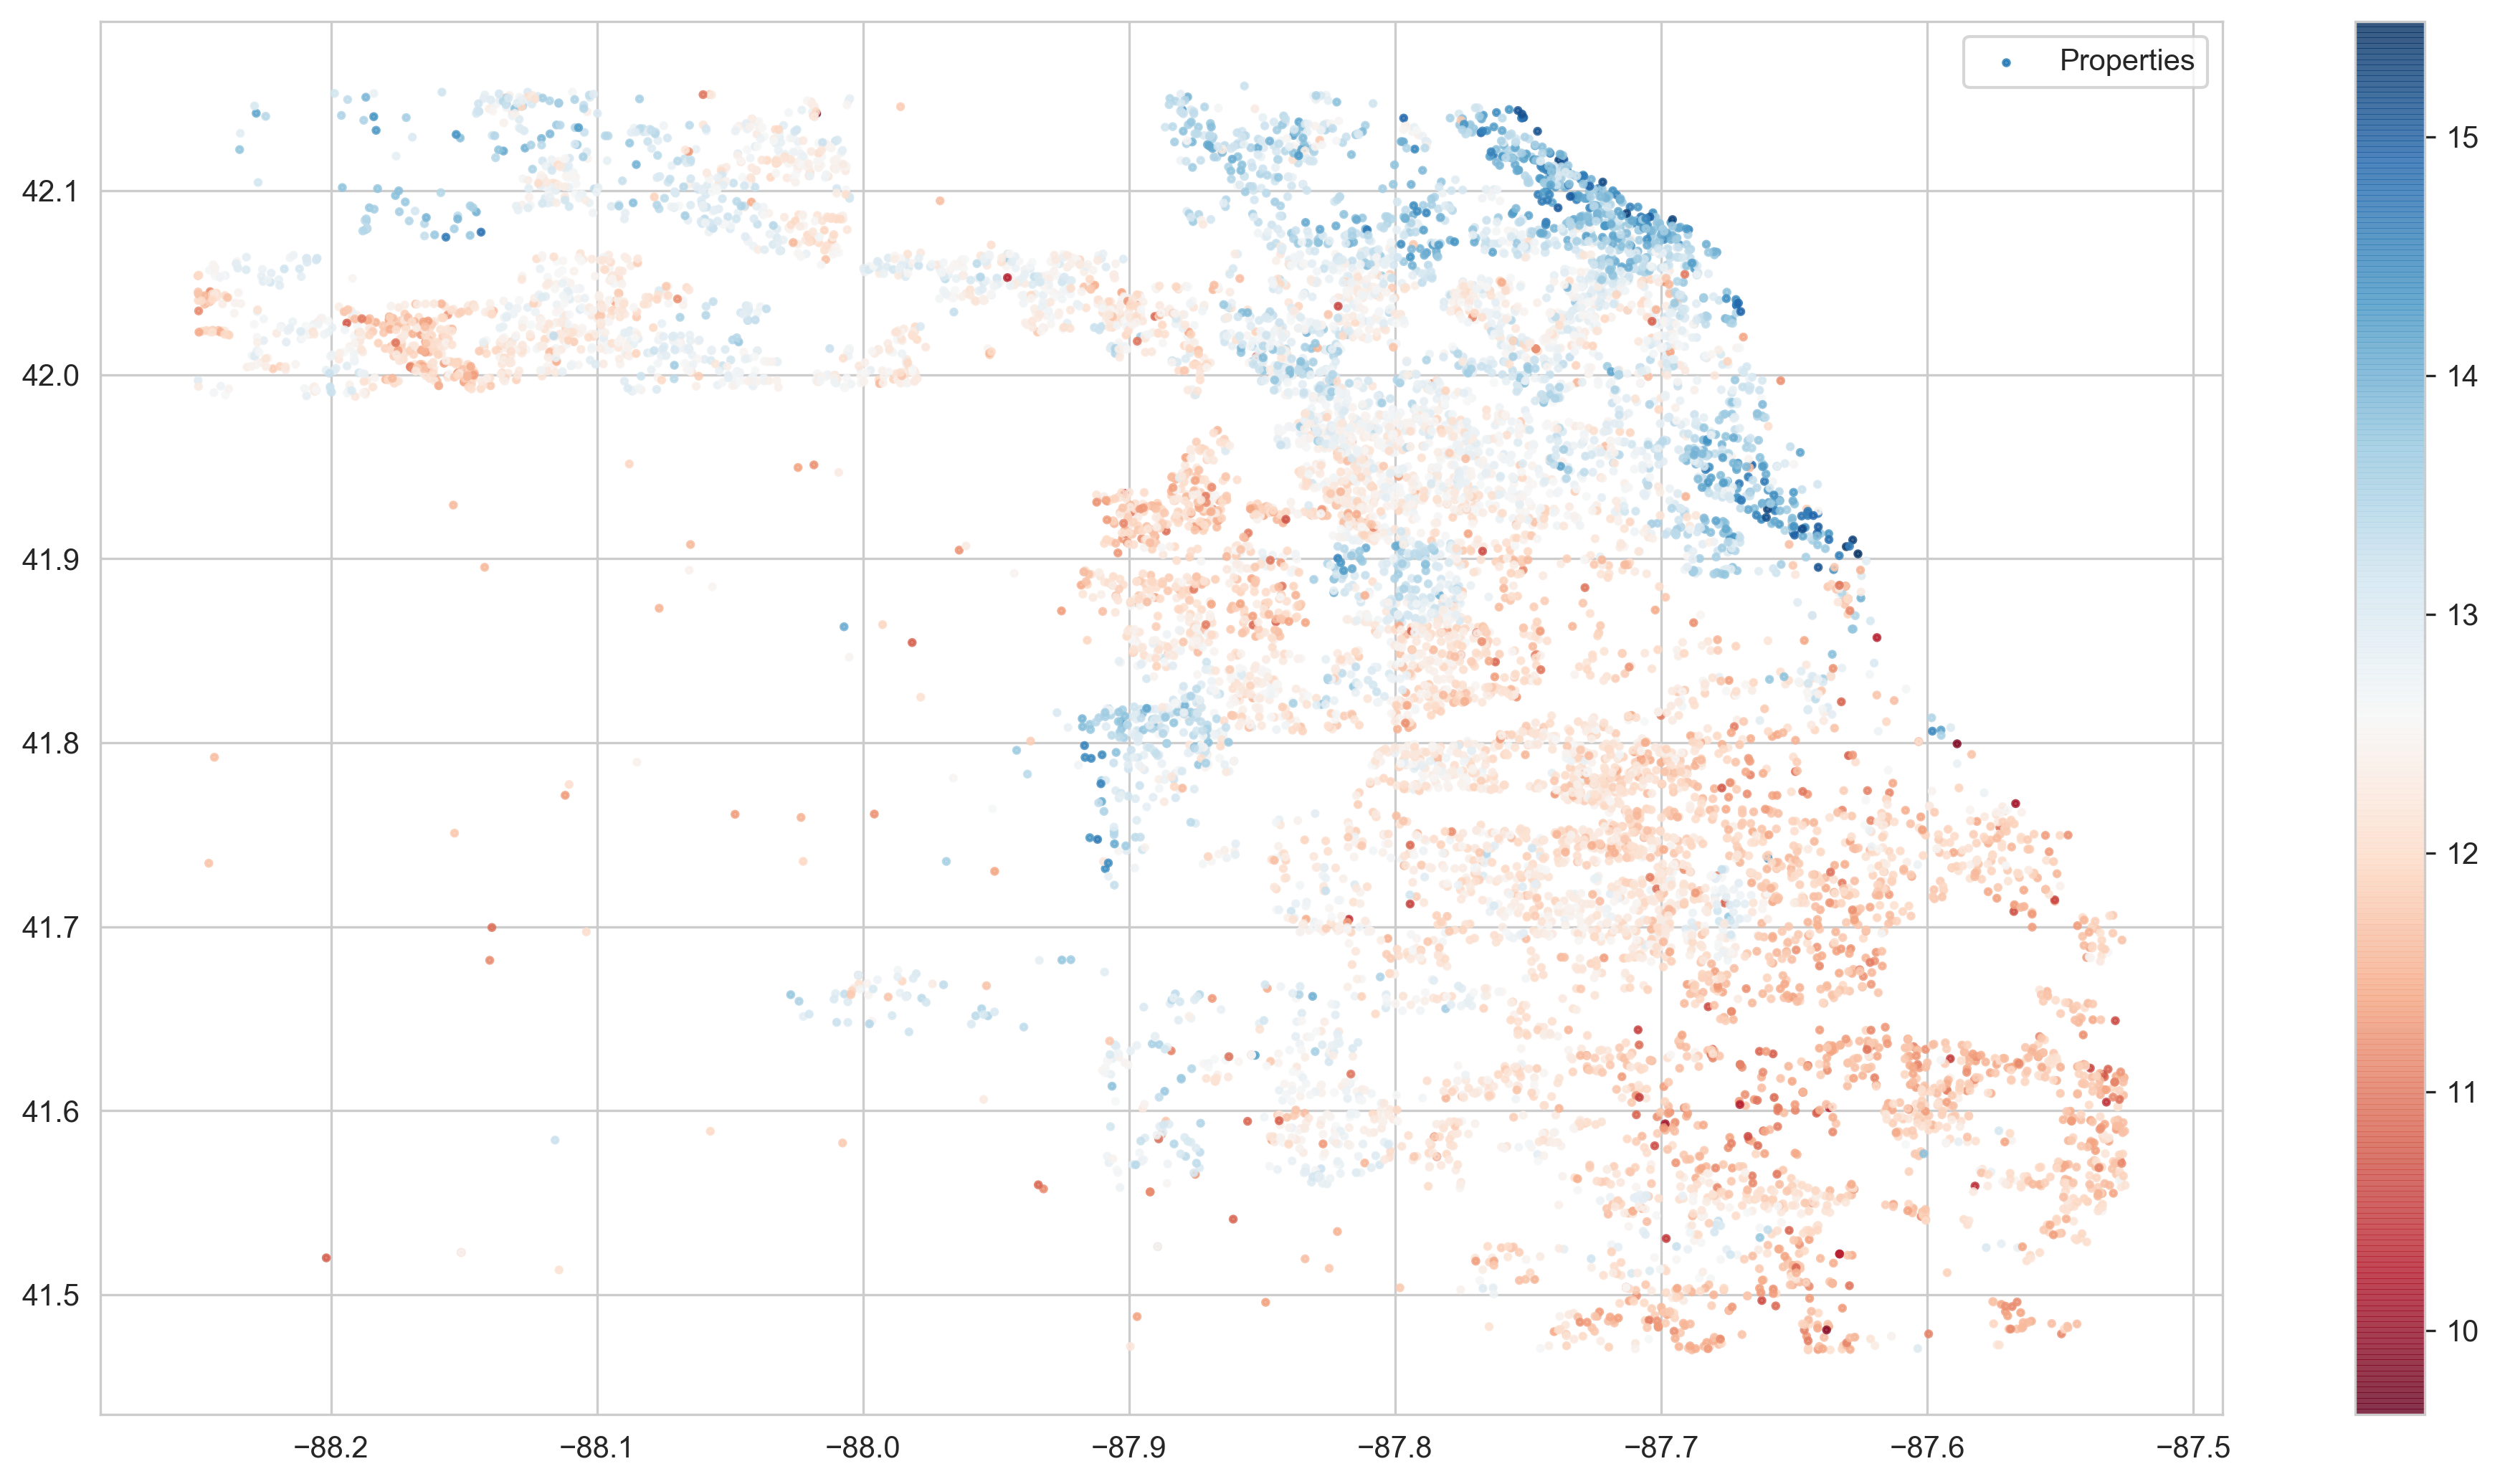

In [19]:
fig = plt.figure(figsize=(13, 7), dpi=300)
plt.scatter(data=df,
            x="Longitude",
            y="Latitude",
            c="log_Sale_Price",
            alpha=0.8,
            s=4,
            cmap=plt.get_cmap("RdBu"),
            label='Properties')
plt.colorbar()
plt.legend()
fig.tight_layout()

`Rooms` and `Bedrooms`

`Bedrooms` seems to be in pretty good shape.

In [20]:
(df.Rooms > 20).sum()

3

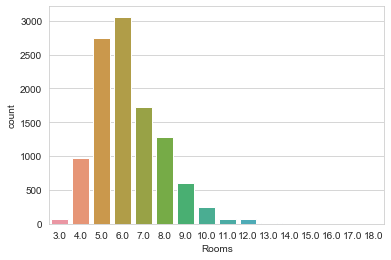

In [21]:
df = df[df.Rooms <= 20]
sns.countplot(x='Rooms', data=df)

`Full_Baths` and `Half_Baths`

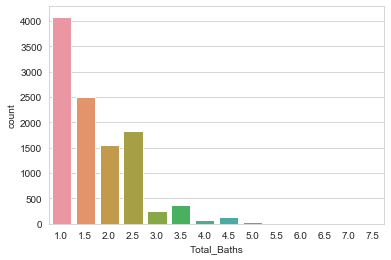

In [22]:
df["Total_Baths"] = df.Full_Baths + df.Half_Baths * 0.5
sns.countplot(x='Total_Baths', data=df)

## 4.4 Categorical Variables

`Basement`

In [23]:
df.Basement.value_counts()

Full basement       4246
1.0                 2087
3.0                 1297
Partial basement    1296
Slab basement        843
2.0                  417
4.0                  353
crawlspace           346
Name: Basement, dtype: int64

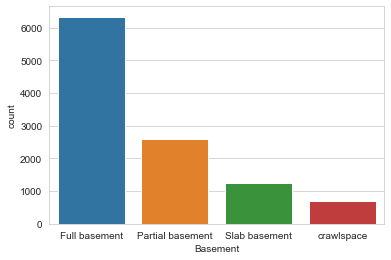

In [24]:
df['Basement'] = df.Basement.replace({
    '0': 'None',
    '1.0': 'Full basement',
    '2.0': 'Slab basement',
    '3.0': 'Partial basement',
    '4.0': 'crawlspace'
}).astype('category')
sns.countplot(x='Basement', data=df)

In [25]:
df['Basement'] = pd.Categorical(df.Basement,
                                categories=[
                                    'Full basement', 'Slab basement',
                                    'Partial basement', 'crawlspace'
                                ])

`Tax_Year`

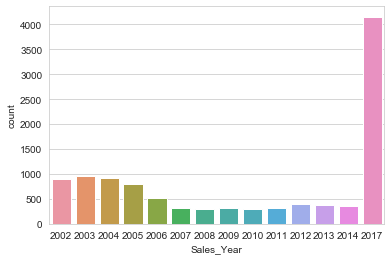

In [26]:
df['Sales_Year'] = (df.Tax_Year - 1).astype('category')
sns.countplot(x='Sales_Year', data=df)

`Type_of_Residence`

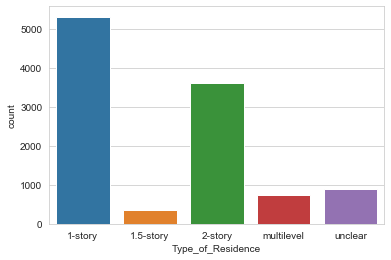

In [27]:
df['Type_of_Residence'] = df.Type_of_Residence.replace({
    '1.0': "1-story",
    '2.0': "2-story",
    '3.0': "multilevel",
    '4.0': "2-story",
    '5.0': "1.5-story",
    '3-story': "multilevel",
    '?': "unclear"
}).astype('category')
sns.countplot(x='Type_of_Residence', data=df)

`Central_Air` and `Fireplaces`

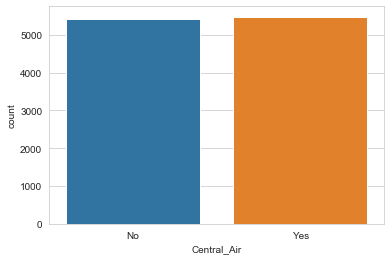

In [28]:
df = df[df.Central_Air != "0"]

df['Central_Air'] = df.Central_Air.replace({
    '1.0': "Yes",
    '2.0': "No"
}).astype('category')
sns.countplot(x='Central_Air', data=df)

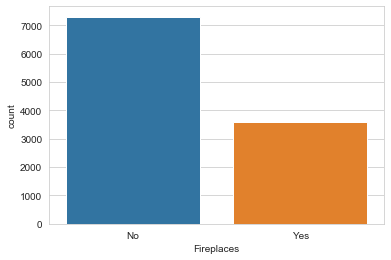

In [29]:
df['Fireplaces'] = pd.Categorical(np.where(df.Fireplaces > 0, "Yes", "No"))
sns.countplot(x='Fireplaces', data=df)

`Walkfac`

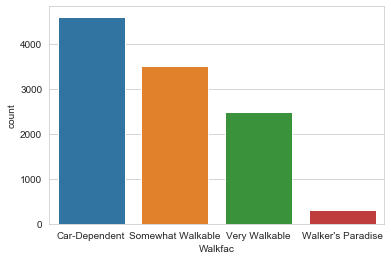

In [30]:
df['Walkfac'] = df.Walkfac.astype('category')
sns.countplot(x='Walkfac', data=df)

`Property_Class`

In [31]:
df['Property_Class'] = df.Property_Class.astype('category')

Drop some unnecessary features.

In [32]:
to_drop = ['Tax_Year', 'Full_Baths', 'Half_Baths', 'Sale_Price']
df.drop(to_drop, axis=1, inplace=True)

# 5. Correlation Analysis and Hypothesis Testing

## 5.1 Correlation Matrix

In [33]:
categoricals = set(df.columns[(df.dtypes == 'category')])
categoricals

{'Age',
 'Area_Code',
 'Basement',
 'Block_Code',
 'Central_Air',
 'Fireplaces',
 'Property_Class',
 'Sales_Year',
 'Sub_Area_Code',
 'Type_of_Residence',
 'Walkfac'}

In [34]:
numericals = set(df.columns) - categoricals - set(['PIN'])
numericals

{'Bedrooms',
 'Building_Square_Feet',
 'Land_Square_Feet',
 'Latitude',
 'Longitude',
 'Rooms',
 'Total_Baths',
 'Walkscore',
 'log_Sale_Price'}

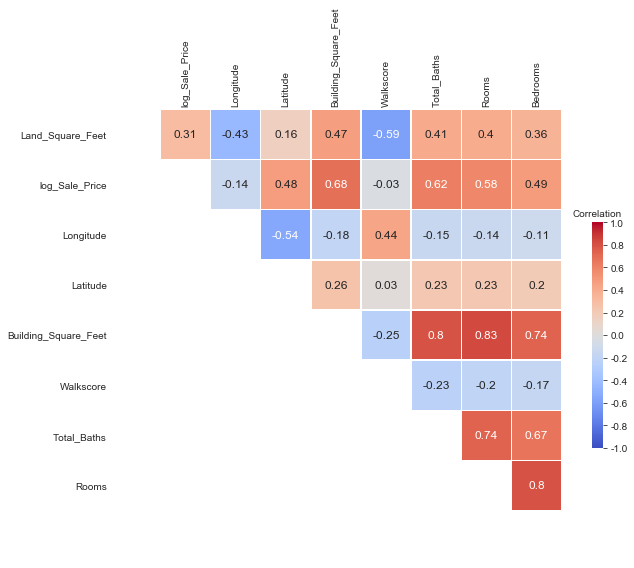

In [35]:
numericals = list(numericals)[1:] + [list(numericals)[0]]

fig, ax = plt.subplots(figsize=(10, 8))
utils.corr_plot(ax,
                df[numericals].corr(),
                numericals,
                cmap="coolwarm",
                triangle=True,
                upper=True,
                font_size=(12, 10, 10),
                annot_size=12,
                decimals=2)
fig.tight_layout()

## 5.2 Hypothesis Testing

In [36]:
scipy.stats.f_oneway(
    *[df[df.Walkfac == level].log_Sale_Price for level in df.Walkfac.unique()])

F_onewayResult(statistic=126.14910047685845, pvalue=2.527670288189958e-80)

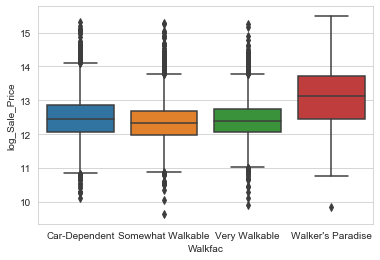

In [37]:
sns.boxplot(data=df, x='Walkfac', y='log_Sale_Price')

In [38]:
scipy.stats.f_oneway(*[
    df[df.Type_of_Residence == level].log_Sale_Price
    for level in df.Type_of_Residence.unique()
])

F_onewayResult(statistic=783.3067762453826, pvalue=0.0)

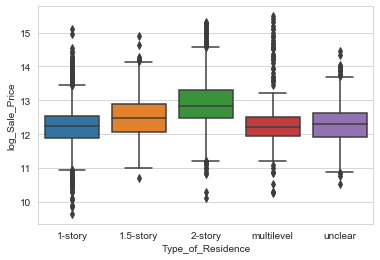

In [39]:
sns.boxplot(data=df, x='Type_of_Residence', y='log_Sale_Price')

# 6. Feature Selection and Feature Engineering

## 6.1 Feature Selection

In [40]:
df.drop(['Walkscore'], axis=1, inplace=True)

## 6.2 Feature Engineering

- Ratios:

In [41]:
df['Bedroom_ratio'] = df.Bedrooms / df.Rooms
df['Bathroom_per_Bedroom'] = df.Total_Baths / df.Bedrooms
df['Sqft_per_room'] = df.Building_Square_Feet / df.Rooms
df['Building_footage_ratio'] = df.Building_Square_Feet / df.Land_Square_Feet

- Discretize geographical coordinates

In [42]:
qs=10

df['Longitude'] = pd.qcut(df.Longitude, q=qs).astype('category')
df['Latitude'] = pd.qcut(df.Latitude, q=qs).astype('category')

- Adding Feature Crosses

In [43]:
df_ = df.copy(deep=True)

In [44]:
ns = df.Sales_Year.nunique()
print("Unique levels in Sales_Year: %s" % ns)

na = df.Area_Code.nunique()
print("Unique levels in Area_Code: %s" % na)

print("Ideal number of features: %s" % (ns+(na-1)+(na-1)*(ns-1)))

Unique levels in Sales_Year: 14
Unique levels in Area_Code: 32
Ideal number of features: 448


In [45]:
crosses = dmatrix('C(Sales_Year)*C(Area_Code)-1', df, return_type="dataframe")
crosses.shape

(10885, 448)

In [46]:
df = pd.concat((df, crosses), axis=1)
df.drop(['Sales_Year', 'Area_Code'], axis=1, inplace=True)

In [47]:
print("Ideal number of features: %s" % (qs+(qs-1)+(qs-1)*(qs-1)))

crosses = dmatrix('C(Longitude)*C(Latitude)-1', df, return_type="dataframe")
crosses.shape

Ideal number of features: 100


(10885, 100)

In [48]:
df = pd.concat((df, crosses), axis=1)
df.drop(['Longitude', 'Latitude'], axis=1, inplace=True)

In [49]:
df.drop(['PIN','Sub_Area_Code', 'Block_Code'], axis=1, inplace=True)

In [54]:
df_.drop(['PIN','Sub_Area_Code', 'Block_Code'], axis=1, inplace=True)

- One-hot-encoding:

In [55]:
df.columns[df.dtypes=='category']

Index(['Property_Class', 'Type_of_Residence', 'Basement', 'Fireplaces',
       'Central_Air', 'Age', 'Walkfac'],
      dtype='object')

In [58]:
df = pd.get_dummies(df,
                    columns=df.columns[df.dtypes == 'category'],
                    drop_first=True)

In [59]:
df_.columns[df_.dtypes=='category']

Index(['Property_Class', 'Type_of_Residence', 'Basement', 'Fireplaces',
       'Central_Air', 'Age', 'Longitude', 'Latitude', 'Walkfac', 'Area_Code',
       'Sales_Year'],
      dtype='object')

In [60]:
df_ = pd.get_dummies(df_,
                    columns=df_.columns[df_.dtypes == 'category'],
                    drop_first=True)

# 7. Explanatory Modeling and Optimization

- Model without feature crosses:

In [61]:
X = df_[[col for col in df_.columns if col != "log_Sale_Price"]]
y = df_.log_Sale_Price

In [62]:
lr = sm.OLS(y, sm.add_constant(X))
res = lr.fit()

print((res.summary()))

                            OLS Regression Results                            
Dep. Variable:         log_Sale_Price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     384.0
Date:                Tue, 14 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:12:41   Log-Likelihood:                -2877.7
No. Observations:               10885   AIC:                             5947.
Df Residuals:                   10789   BIC:                             6648.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

- Model with feature crosses:

In [63]:
X = df[[col for col in df.columns if col != "log_Sale_Price"]]
y = df.log_Sale_Price

In [64]:
lr = sm.OLS(y, sm.add_constant(X))
res = lr.fit()

print((res.summary()))

                            OLS Regression Results                            
Dep. Variable:         log_Sale_Price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     98.77
Date:                Tue, 14 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:13:51   Log-Likelihood:                -1996.3
No. Observations:               10885   AIC:                             4873.
Df Residuals:                   10445   BIC:                             8083.
Df Model:                         439                                         
Covariance Type:            nonrobust                                         
                                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

D:\Anaconda\envs\teaching\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
D:\Anaconda\envs\teaching\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Anaconda\envs\teaching\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Anaconda\envs\teaching\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# 8. Conclusion